Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [2]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [3]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Store buckets

___
### Movielens

In [4]:
# importa dataset 'movielensm1'
data = pd.read_csv("../datasets/ml1m_gte5.csv","\t")
# Necessary Preprocess - create date from timestamp
data['date'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).date() )
data['year'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).year)
data['month'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).month )
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

In [177]:
# this lets me sample the first 10% of the dataset to avoid cold start.
# data.iloc[ :int( 0.1*data.shape[0] ) ]

#### Evaluating Time defined Buckets 

How many interactions occur in each month?

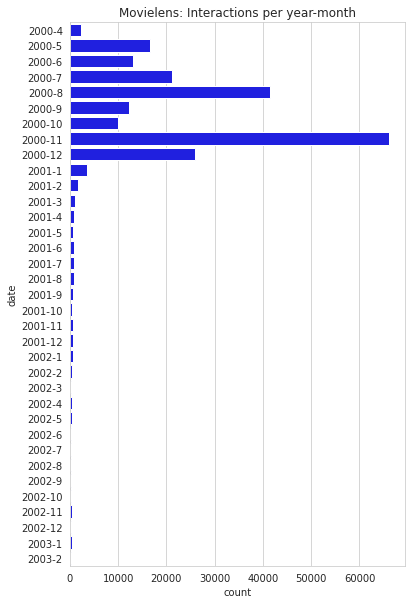

In [8]:
plot_interactions_per_month(data=data, dataset_name='Movielens')

What is the user presence distribution based on month, quarter, and semester?

In [171]:
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col='UserID')

In [176]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
5941,195,0.742857,0.833333,0.833333
3975,1088,0.685714,0.833333,0.833333
4950,1733,0.628571,0.833333,0.833333
5398,343,0.600000,0.833333,0.833333
5768,424,0.571429,0.833333,0.833333


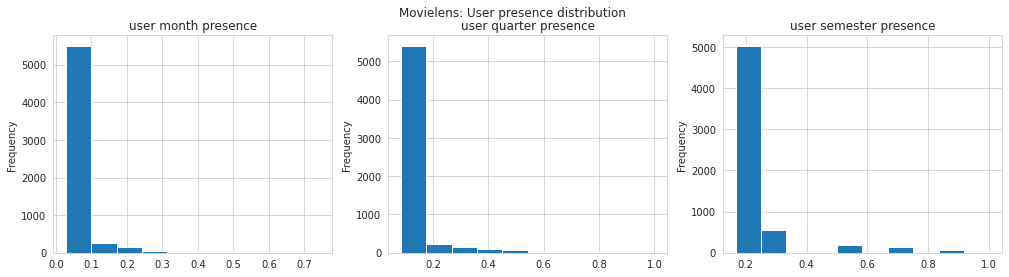

In [11]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name='Movielens')

How many examples are there per quarter and semester?

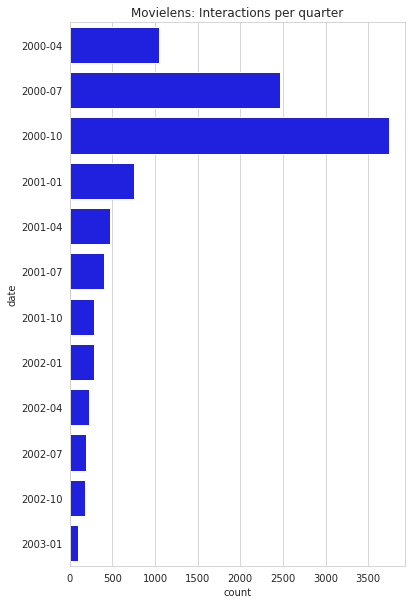

In [12]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name='Movielens', type_of_range='quarter')

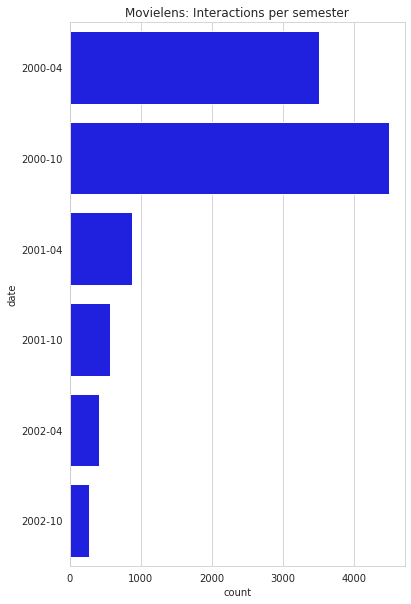

In [13]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name='Movielens', type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [ ]:
# defining threshold
frequency_threshold = 0.8

In [180]:
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

0 users of 6014 (0.0%) occurr in 80.0% or more months (of 35).
9 users of 6014 (0.15%) occurr in 80.0% or more quarters (of 12).
93 users of 6014 (1.546%) occurr in 80.0% or more semesters (of 6).


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [204]:
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
freq_user_quarter_info

,possible_holdout_users,median_freq_user_interactions
0,2,0.0
1,1,0.0
2,5,2.0
3,7,2.0
4,6,2.0
5,5,2.0
6,5,2.0
7,7,2.0
8,7,3.0
9,6,3.0


In [202]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [203]:
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
freq_user_semester_info

,possible_holdout_users,median_freq_user_interactions
0,33,1.0
1,72,2.0
2,57,2.0
3,47,2.0
4,53,2.0
5,32,1.0


In [205]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [206]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];

#### Evaluating Interactions 50E3 sized Buckets 

In [209]:
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

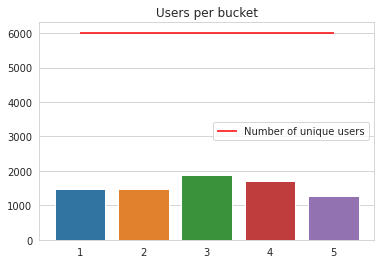

In [218]:
plot_users_per_fixed_bucket(data, 'UserID', interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [241]:
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, 'UserID', interval_start, interval_end)

In [110]:
frequency_threshold

0.8

In [232]:
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

83 users of 6014 (1.38%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [238]:
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)
freq_user_bucket_info

(0    51
 1    74
 2    57
 3    29
 4    73
 Name: possible_holdout_users, dtype: int64,
 0    20.0
 1     7.0
 2     3.0
 3     1.0
 4     8.0
 Name: median_freq_user_interactions, dtype: float64)

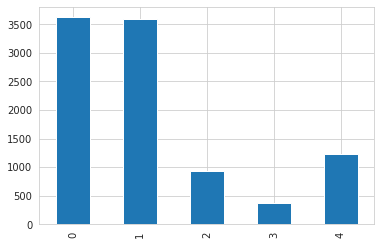

In [242]:
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

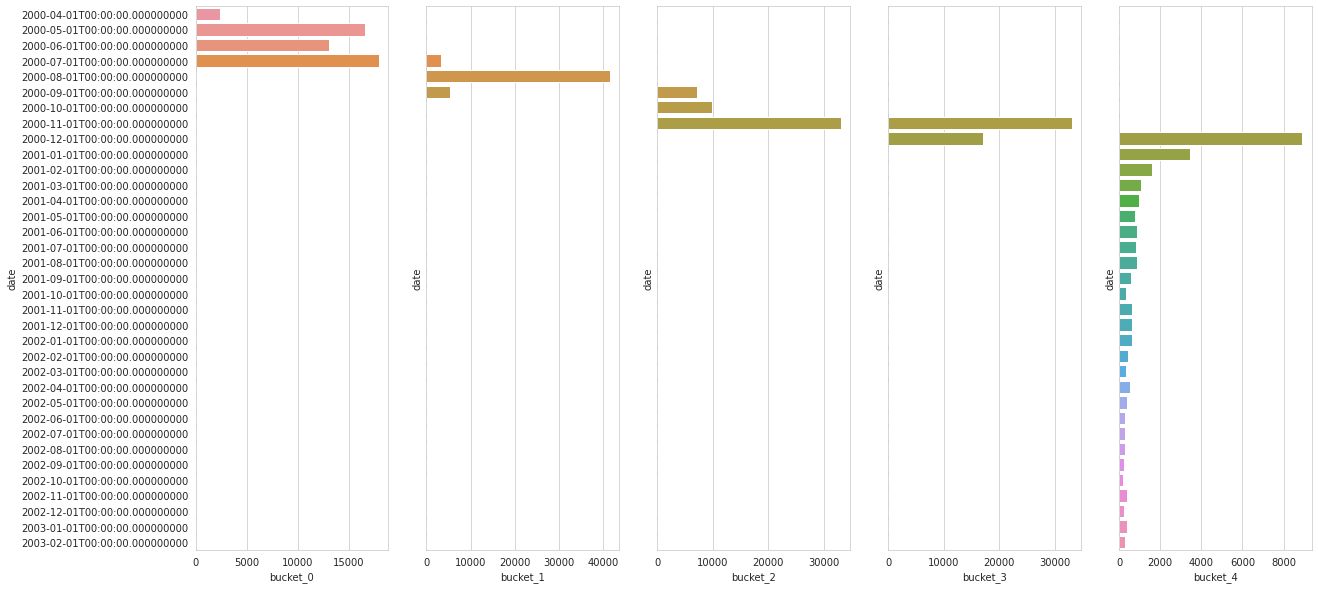

In [249]:
plot_timestamps_per_bucket(dates_fixed_buckets_df)

___

In [13]:
num_factors = 160
num_iter = 8
learn_rate = 0.1
regularization = 0.4
num_nodes = 8

In [14]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['UserID'], data['ItemID'])

empty_stream = ImplicitData([], [])

In [15]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [16]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_movielens = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [17]:
%%time
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_movielens.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 1:40 min

25 stored in 3
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
24 stored in 3
25 used in training
24 used in training
24 used in training
25 used in training
24 used in training
25 used in training
25 used in training
24 used in training
25 used in training
24 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 stored in 3
25 used in training
25 used in training
25 used in training
25 stored in 3
24 used in training
24 used in training
24 stored in 3
24 used in training
24 stored in 3
24 used in training
24 used in training
25 used in training
25 used in training
24 used in training
24 used in training
24 used in training
24 used in training
24 used in training
24 used in training
22 used in training
22 stored in 3
22 used in training
22 stored in 3
24 stored in 3
22 used in training
24 used in training
22 us

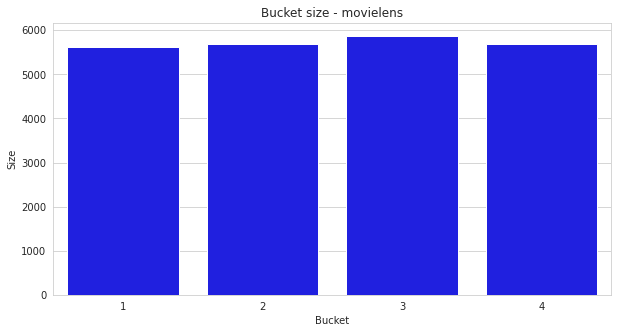

In [32]:
plot_bucket_size(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_bucket_size.png')

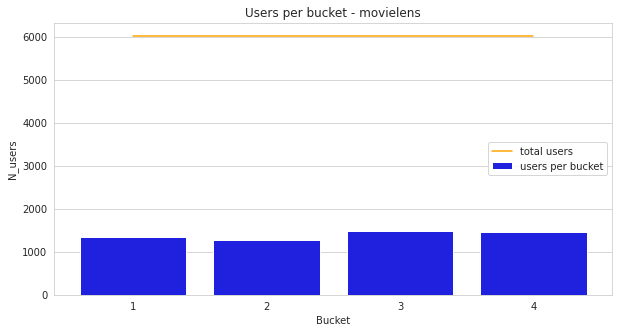

In [33]:
plot_n_users_per_bucket(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_user_per_bucket.png')

In [57]:
movielens_ubm = get_bucket_map(eval_object=eval_movielens)
movielens_median_user_presence = median_user_presence_per_bucket(eval_object=eval_movielens, user_bucket_map=movielens_ubm)
print( movielens_median_user_presence )
store_user_presence(dataset_name='movielens', median_user_presence=movielens_median_user_presence)

In [55]:
joblib.dump(movielens_ubm, 'output/joblib_bucket_info_dump/movielens_ubm', compress=True)

['output/joblib_bucket_info_dump/movielens_ubm']

___

In [ ]:
data = pd.read_csv("../datasets/ymusic_gte90_6kusers.tsv","\t")
stream = ImplicitData(data['user_id'],data['item_id'])
empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 200
num_iter = 9
learn_rate = 0.25
regularization = 0.45
num_nodes = 16

In [ ]:
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_ymusic = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_ymusic.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 42 min

In [ ]:
joblib.dump(eval_ymusic, 'output/joblib_bucket_info_dump/eval_ymusic', compress=True)

___
### Lastfm

In [ ]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/lastfm_50u.tsv","\t")

# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)

# Evaluation

In [ ]:
# def plot_n_users_per_bucket(eval_object:EvaluateAndStore, dataset_name:str, filename:str=None):
#     n_users = len( eval_object.data.userset )
#     n_users_bucket = pd.Series( [len( bucket.userset ) for bucket in eval_object.holdouts] )
#     n_users_bucket = n_users_bucket.reset_index()
#     n_users_bucket.columns = ['Bucket', 'N_users']
#     n_users_bucket['Bucket'] = n_users_bucket['Bucket']+1
#     plt.figure(figsize=(10,5))
#     sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
#     sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
#     plt.title(f'Users per bucket - {dataset_name}');
#     if filename:
#         plt.savefig(f'images/user_bucket_analysis/{filename}')

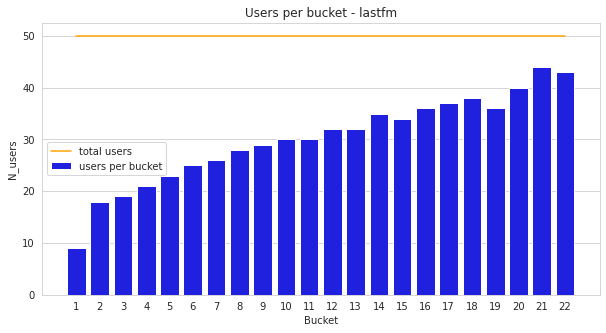

14.0

In [97]:
[bucket.userset for bucket in eval_lastfm.holdouts]

[array(['user_000174', 'user_000337', 'user_000407', 'user_000707',
        'user_000709', 'user_000751', 'user_000957', 'user_000984',
        'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000337', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000807', 'user_000882', 'user_000912', 'user_000957',
        'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000337', 'user_000374', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000767', 'user_000807', 'user_000882', 'user_000912',
        'user_000957', 'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000330', 'user_000337',
        'user_000374',

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange');

3784